In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import time

#Set a random seed for reproducibility
torch.manual_seed(42)

class LyricsDataset(Dataset):
    def __init__(self, csv_paths, seq_length=50, step=1):
        # Read and concatenate the data from CSV files
        dataframes = [pd.read_csv(path) for path in csv_paths]
        lyrics_data = pd.concat(dataframes)

        # Concatenate all lyrics into a single string
        lyrics_text = lyrics_data['lyric'].str.cat(sep='\n').lower()

        # Create a sorted list of unique characters
        chars = sorted(list(set(lyrics_text)))
        self.char_to_int = {c: i for i, c in enumerate(chars)}
        self.int_to_char = {i: c for i, c in enumerate(chars)}

        # Create the sequences
        self.sentences = []
        self.next_chars = []
        for i in range(0, len(lyrics_text) - seq_length, step):
            self.sentences.append(lyrics_text[i: i + seq_length])
            self.next_chars.append(lyrics_text[i + seq_length])

        # Call getdata to preprocess the data
        self.X, self.y = self.getdata(seq_length)

    def getdata(self, seq_length):
        X = np.zeros((len(self.sentences), seq_length), dtype=int)
        y = np.zeros(len(self.sentences), dtype=int)
        for i, sentence in enumerate(self.sentences):
            for t, char in enumerate(sentence):
                X[i, t] = self.char_to_int[char]
            y[i] = self.char_to_int[self.next_chars[i]]
        return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Paths to your CSV files
csv_paths = [
    "./01-taylor_swift.csv",
    "./02-fearless_taylors_version.csv",
    "./03-speak_now_deluxe_package.csv",
    "./04-red_deluxe_edition.csv",
    "./05-1989_deluxe.csv",
    "./06-reputation.csv",
    "./07-lover.csv",
    "./08-folklore_deluxe_version.csv",
    "./09-evermore_deluxe_version.csv"
]

# Create an instance of the LyricsDataset
dataset = LyricsDataset(csv_paths)

# Use DataLoader to create batches
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

train_size = int(0.8 * len(dataset))  # 80% of the dataset for training
val_size = len(dataset) - train_size  # Remaining 20% for validation
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

class Simple_LSTM(nn.Module):
    def __init__(self, n_vocab, hidden_dim, embedding_dim, dropout=0.2):
        super(Simple_LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, dropout=dropout, num_layers=3)
        self.embeddings = nn.Embedding(n_vocab, embedding_dim)
        self.fc = nn.Linear(hidden_dim, n_vocab)
    
    def forward(self, seq_in):
        # Transpose the input for LSTM
        embedded = self.embeddings(seq_in.t()) 
        lstm_out, _ = self.lstm(embedded)
        # Use the last character's output
        ht = lstm_out[-1] 
        out = self.fc(ht)
        return out



# Initialize the model with dynamic n_vocab
n_vocab = len(dataset.char_to_int)
model = Simple_LSTM(n_vocab, 256, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

# Training and validation loop
n_epochs = 20
avg_losses_f = []
avg_val_losses_f = []

best_val_loss = float('inf')# Placeholder for model saving logic

from tqdm import tqdm

for epoch in tqdm(range(n_epochs)):
    start_time = time.time()
    
    # Training phase
    model.train()
    avg_loss = 0.
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() / len(train_loader)

    # Validation phase
    model.eval()
    avg_val_loss = 0.
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            y_val_pred = model(x_val)
            val_loss = loss_fn(y_val_pred, y_val)
            avg_val_loss += val_loss.item() / len(val_loader)

    elapsed_time = time.time() - start_time
    print(f'Epoch {epoch + 1}/{n_epochs} \t loss={avg_loss:.4f} \t val_loss={avg_val_loss:.4f} \t time={elapsed_time:.2f}s')

    avg_losses_f.append(avg_loss)
    avg_val_losses_f.append(avg_val_loss)

    # Save the model if validation loss has improved
    if avg_val_losses_f[-1] < best_val_loss:
        best_val_loss = avg_val_losses_f[-1]
        torch.save(model.state_dict(), 'best_model.pth')
        print("Model saved at epoch", epoch + 1)

# Print average losses
print(f'Average training loss: {np.mean(avg_losses_f):.4f}')
print(f'Average validation loss: {np.mean(avg_val_losses_f):.4f}')


Using device: mps


  5%|██▏                                         | 1/20 [01:01<19:34, 61.81s/it]

Epoch 1/20 	 loss=1.7757 	 val_loss=1.5440 	 time=61.79s
Model saved at epoch 1


 10%|████▍                                       | 2/20 [02:03<18:31, 61.76s/it]

Epoch 2/20 	 loss=1.4512 	 val_loss=1.4386 	 time=61.71s
Model saved at epoch 2


 15%|██████▌                                     | 3/20 [03:05<17:29, 61.71s/it]

Epoch 3/20 	 loss=1.3689 	 val_loss=1.3953 	 time=61.64s
Model saved at epoch 3


 20%|████████▊                                   | 4/20 [04:08<16:39, 62.44s/it]

Epoch 4/20 	 loss=1.3243 	 val_loss=1.3694 	 time=63.55s
Model saved at epoch 4


 25%|███████████                                 | 5/20 [05:10<15:34, 62.30s/it]

Epoch 5/20 	 loss=1.2954 	 val_loss=1.3516 	 time=62.04s
Model saved at epoch 5


 30%|█████████████▏                              | 6/20 [06:12<14:28, 62.06s/it]

Epoch 6/20 	 loss=1.2721 	 val_loss=1.3273 	 time=61.58s
Model saved at epoch 6


 35%|███████████████▍                            | 7/20 [07:13<13:24, 61.87s/it]

Epoch 7/20 	 loss=1.2589 	 val_loss=1.3221 	 time=61.47s
Model saved at epoch 7


 40%|█████████████████▌                          | 8/20 [08:15<12:20, 61.75s/it]

Epoch 8/20 	 loss=1.2433 	 val_loss=1.3210 	 time=61.46s
Model saved at epoch 8


 45%|███████████████████▊                        | 9/20 [09:16<11:18, 61.70s/it]

Epoch 9/20 	 loss=1.2348 	 val_loss=1.3107 	 time=61.60s
Model saved at epoch 9


 50%|█████████████████████▌                     | 10/20 [10:18<10:15, 61.58s/it]

Epoch 10/20 	 loss=1.2243 	 val_loss=1.3167 	 time=61.31s


 55%|███████████████████████▋                   | 11/20 [11:20<09:16, 61.78s/it]

Epoch 11/20 	 loss=1.2216 	 val_loss=1.3115 	 time=62.23s


 60%|█████████████████████████▊                 | 12/20 [12:22<08:13, 61.70s/it]

Epoch 12/20 	 loss=1.2167 	 val_loss=1.3076 	 time=61.51s
Model saved at epoch 12


 65%|███████████████████████████▉               | 13/20 [13:23<07:11, 61.63s/it]

Epoch 13/20 	 loss=1.2082 	 val_loss=1.3000 	 time=61.45s
Model saved at epoch 13


 70%|██████████████████████████████             | 14/20 [14:25<06:09, 61.63s/it]

Epoch 14/20 	 loss=1.2091 	 val_loss=1.3109 	 time=61.62s


 75%|████████████████████████████████▎          | 15/20 [15:26<05:08, 61.63s/it]

Epoch 15/20 	 loss=1.2068 	 val_loss=1.3049 	 time=61.62s


 80%|██████████████████████████████████▍        | 16/20 [16:28<04:06, 61.60s/it]

Epoch 16/20 	 loss=1.2026 	 val_loss=1.2984 	 time=61.54s
Model saved at epoch 16


 85%|████████████████████████████████████▌      | 17/20 [17:29<03:04, 61.56s/it]

Epoch 17/20 	 loss=1.2008 	 val_loss=1.3013 	 time=61.45s


 90%|██████████████████████████████████████▋    | 18/20 [18:31<02:03, 61.53s/it]

Epoch 18/20 	 loss=1.1977 	 val_loss=1.3046 	 time=61.48s


 95%|████████████████████████████████████████▊  | 19/20 [19:32<01:01, 61.51s/it]

Epoch 19/20 	 loss=1.1950 	 val_loss=1.3027 	 time=61.45s


100%|███████████████████████████████████████████| 20/20 [20:34<00:00, 61.71s/it]

Epoch 20/20 	 loss=1.1963 	 val_loss=1.3053 	 time=61.62s
Average training loss: 1.2752
Average validation loss: 1.3372


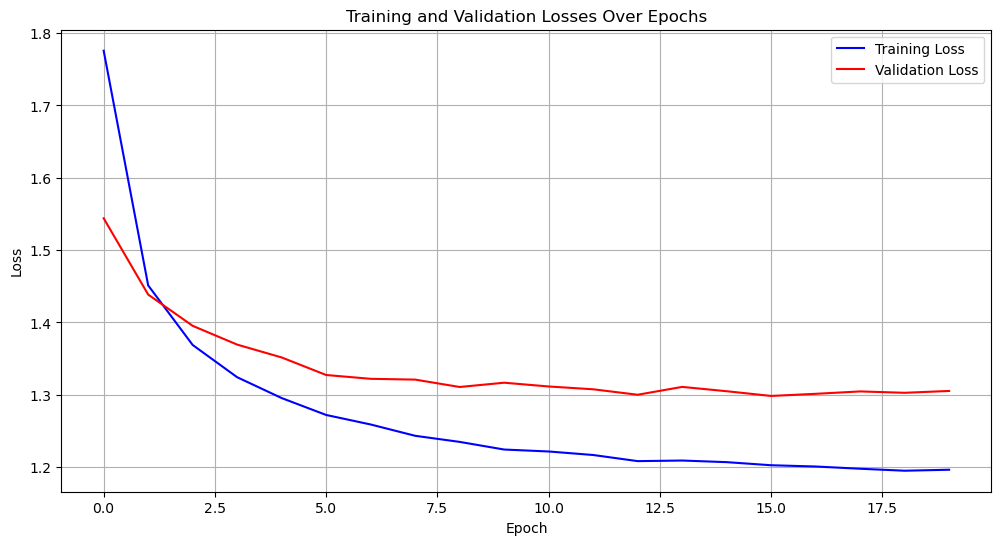

In [16]:
import matplotlib.pyplot as plt

# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(avg_losses_f, label='Training Loss', color='blue')

# Plot validation loss
plt.plot(avg_val_losses_f, label='Validation Loss', color='red')

# Add title and labels
plt.title('Training and Validation Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Add a legend
plt.legend()
plt.grid()
# Show the plot
plt.show()


# Generation text

In [20]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# Define the start sentence for the Taylor Swift lyrics predictor
sentence = "It's me, hi, I'm the problem, it's me \nAt tea time, everybody agrees"

variance = 0.25  # Temperature for sampling
generated = ''
original = sentence
window = sentence

seq_length = 50  # Length of the sequence used for training

for i in range(150):  # Generate 100 characters
    # Ensure window is exactly seq_length characters
    while len(window) < seq_length:
        window = ' ' + window  # Add padding if necessary
    window = window[-seq_length:]  # Truncate to seq_length

    x = np.zeros((1, seq_length))
    for t, char in enumerate(window):
        x[0, t] = dataset.char_to_int[char] if char in dataset.char_to_int else 0
        
    x_in = Variable(torch.LongTensor(x).to(device))
    pred = model(x_in)
    pred = np.array(F.softmax(pred, dim=1).data[0].cpu())
    next_index = sample(pred, variance)
    next_char = dataset.int_to_char[next_index]

    generated += next_char
    window = window[1:] + next_char  # Slide the window

print(original + generated)


It's me, hi, I'm the problem, it's me 
At tea time, everybody agrees on the deatay on the teace to tell and theney toning time
and then theney and theney toning to me of the fent for a catcate on the corn and teakentat
